## Whole Cell Gridding Code

This algorithm eseentailly just looks at the outline of a cell as a "line" point by point

It then takes that "line" and creates squares normal to the contour on it 

Then checks those against other squares for overlap and removes excessively overlapping ones


This currently just draws squares, but if that's possible it shouldn't be too complex to extract images from the defined squares

I think cv2.getPerspectiveTransform might be useful for that

In [79]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


#Read image and threshold for mask:
#This basic method works best with already cropped cells
#I have another at the bottom that is slightly better for cells with backgrounds
image1=cv2.imread("h2114153  h&e_ROI_1 Epithelia.png")
image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
_,whole_thresh=cv2.threshold(image1_gray,1,255,cv2.THRESH_BINARY)


In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# It is designed to take in a cell that has been seperated from the background
# The mask/thresh should have clear lines for a contour to be drawn along

def find_largest_countour(binary_image):
    """Calulate the largest vector in a binary image-typically the outline"""
    contours, _=cv2.findContours(binary_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    return max(contours,key=cv2.contourArea)


def calculate_contour_normals(contour,smooting_size=5):
    """
    Calculate normal vectors along the contour
    """
    #The normal vector is parallel to contour at a point and ensures the square goes in to the cell
    #Smoothing size is how many points before and after current to look back and find tangent
    
    #Reshape contour into (x,y) pairings
    points=contour.reshape(-1,2)
    n_points=len(points)
    tangents=np.zeros_like(points,dtype=float)

    for i in range(n_points):
        #get indices, % handles wraparound
        prev_idx=(i-smooting_size)%n_points
        next_idx=(i+smooting_size)%n_points
        tangent=points[next_idx]-points[prev_idx]

        #divide by length of tangent to normalize and add num for stability
        tangent=tangent/(np.linalg.norm(tangent)+1e-8)
        tangents[i]=tangent

    #This just rotates the tangents to find normals
    #Negative from next-prev approach, could switch normals' signs for outward pointing 
    normals=np.zeros_like(tangents)
    normals[:,0]=-tangents[:,1]
    normals[:,1]=tangents[:,0]

    return normals

def calculate_square_corners(point,normal,square_size):
    """Caluclate square corners so that top edge is touching the contour point"""
    #Find tangent for point for top edge (inverse of previous formula)
    tangent=np.array([-normal[1],normal[0]])
    half_size=square_size/2


    #Take point and extend from it in tangent and normal directions
    #Normalization allows for multiplication by square size
    corners=np.array([
        point+(tangent*half_size),
        point-(tangent*half_size),
        point-(tangent*half_size)-(normal*square_size),
        point+(tangent*half_size)-(normal*square_size)
    ])
    return corners

def calculate_overlap_area(square1,square2):
    """
    Calculate approx overlap between two squares
    Return ovelap area and center-center dist
    """
    #Average x and y to find center
    center1=np.mean(square1,axis=0)
    center2=np.mean(square2,axis=0)
    distance=np.linalg.norm(center1-center2)

    #Calculate the diagonal distance of the first square (using opposite corners)
    diagonal=np.linalg.norm(square1[0]-square1[2])
    #Rudimentary distance calculation, how much of the distance could be explained by overlapping diagonals
    overlap=max(0,1-(distance/diagonal))

    return overlap,distance

def create_dense_squares(contour,normals,square_size=64,step=5):
    """Create dense squares along the contour"""
    points=contour.reshape(-1,2)
    n_points=len(points)
    squares=[]
    indices=[]

    #Create squares at intervals
    for i in range(0,n_points,step):
        corners=calculate_square_corners(points[i],normals[i],square_size)
        squares.append(corners)
        indices.append(i)

    return squares,indices

def remove_overlapping_squares(squares,indices,overlap_thresh=0.3):
    """
    Remove overlapping squares but continue continuity
    Uses a greedy-based approach
    """
    if not squares:
        return [],[]
    
    n_squares=len(squares)
    kept_squares=[]
    kept_indices=[]
    excluded=set()

    #Keep first
    kept_squares.append(squares[0])
    kept_indices.append(indices[0])
    last_kept_idx=0

    #Remaining squares in sequence
    for i in range(1,n_squares):
        if i in excluded:
            continue

        current_square=squares[i]
        overlap_found=False


        #Check for overlap with recent squares
        for j in range(max(0,len(kept_squares)-3),len(kept_squares)):
            overlap,distance=calculate_overlap_area(current_square,kept_squares[j])

            if overlap>overlap_thresh:
                overlap_found=True
                break
            #Keep squares that meet thresh
            if not overlap_found:
                kept_squares.append(current_square)
                kept_indices.append(indices[i])
                last_kept_idx=i

            #Mark squares to exclude if they're too close to the current one
            for k in range(i+1, min(i+3,n_squares)):
                overlap, _=calculate_overlap_area(current_square,squares[k])
                if overlap>overlap_thresh:
                    excluded.add(k)
        
    return kept_squares,kept_indices

def draw_image_squares(image,squares,color=(255,0,0),thickness=20):
    """"Draw kept squares on image"""
    grid_img=image.copy()

    for square in squares:
        points=square.astype(np.int32)
        cv2.polylines(
            grid_img,
            [points],
            isClosed=True,
            color=color,
            thickness=thickness
        )
    return grid_img

def normal_squares_from_contour(image,binary_image,square_size=64,step=5,overlap_thresh=0.3,smoothing_size=5):
    """
    Main function to find normals and tangents of contour and create corresponding squares

    Args:
        image: Original Image
        binary_mask: Binary mask of main shape
        square_size:Desired size of squares
        step: points to skip between initial dense squares drawing
        overlap_threshold:Max allowed overlap between squares (0-1)
        smoothing_size:# of Points considered before and after when creating normals
        
    """

    contour=find_largest_countour(binary_image)
    normals=calculate_contour_normals(contour,smooting_size=smoothing_size)

    #Create initial squares
    squares,indices=create_dense_squares(contour,normals,square_size=square_size,step=step)

    #Remove overlapping
    final_squares,final_indices=remove_overlapping_squares(squares,indices,overlap_thresh=overlap_thresh)

    grid_img=draw_image_squares(image,final_squares)

    #Plot image and contour
    plt.imshow(grid_img)
    plt.plot(contour[:,0,0],contour[:,0,1],'r',alpha=0.5,label='Contour')

    return grid_img,contour,squares

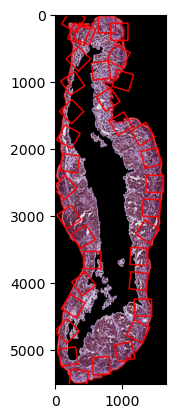

In [76]:
result_image, contour, squares = normal_squares_from_contour(
     image1,
     whole_thresh,
     square_size=256,
     step=5,
     overlap_thresh=0.01,
     smoothing_size=2
 )

### Below is a basic approach to thresholding and masking an image that still has its white background


```python
image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
_,whole_thresh=cv2.threshold(image1_gray,200,255,cv2.THRESH_BINARY)#+cv2.THRESH_OTSU)
whole_thresh_inv=cv2.bitwise_not(whole_thresh)
whole_thresh=whole_thresh_inv
plt.imshow(whole_thresh_inv,cmap='gray')
```